# Please open notebook in colab 

# PCA and TSNE results can be seen in colab and are not presentable in VScode

1. Download the MNIST dataset and create a dataloader that adds gaussian noise to the input images.
2. Design and train an AutoEncoder on the MNIST dataset to denoise the noisy images.
3. Randomly choose one image for each digit and visualize the initial images and their corresponding noisy images and decoded images side by side.
4. Compute latent feature vectors of images. (The output of the encoder network)
5. Use PCA to reduce the dimensionality of latent features to 2 and visualize the data points in a scatter plot. Use a different color for each digit.
6. Repeat the previous step with TSNE.
7. What do you conclude from steps 4 and 5 about the learned latent representation of the data?

Bonus:
1. Create a data loader that rotates input images with a random degree.
2. Design and train a Variational AutoEncoder that gets rotated images as input and outputs an image so that the digit in the image would become horizontal.

Useful links:
- [AE](https://medium.com/@AnasBrital98/autoencoders-explained-da131e60e02a)
- [VAE](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)
- [PCA](https://towardsdatascience.com/the-most-gentle-introduction-to-principal-component-analysis-9ffae371e93b#:~:text=From%20Wikipedia%2C%20PCA%20is%20a,find%20unmeasured%20%E2%80%9Clatent%20variables%E2%80%9D.)
- [T-SNE](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a)

### import required libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd


In [ ]:
# NOTE: It is highly recommended to use colab GPUs!
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### config

In [ ]:
config = {
    'batch_size' : 64 , 
    'num_workers' : 1 ,
    'eopches' : 20 ,
    'learning_rate' : 0.0005
}

### noise tranform

In [ ]:
class GaussianNoise(object): 
    def __init__(self, mean=0., std=0.1): 

        self.std = std
        self.mean = mean

    def __call__(self, tensor): 

        return tensor + torch.randn(tensor.size()) * self.std + self.mean

### MNIST dataset

In [ ]:
original_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform =transforms.Compose([
                       transforms.ToTensor()]),
    download = True,            
)

noisy_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform=transforms.Compose([
                       transforms.ToTensor(),
                       GaussianNoise()]), 
    download = True,            
)

In [ ]:
train_data_loader = torch.utils.data.DataLoader(dataset=noisy_data,batch_size=64,shuffle=True)


### Autoencoder model

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder , self).__init__()        
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 16) ,
            nn.ReLU(),
            nn.Linear(16, 10)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded_data = self.encoder(x)
        decoded_data = self.decoder(encoded_data)
        return decoded_data


### parameters

In [ ]:
model = Autoencoder()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),config['learning_rate'],weight_decay=1e-5)
model.to('cuda')

### train function

In [ ]:
def train(model,trainloader,loss_func,optimizer):
    
    total_step_train=len(trainloader)

    for epoch in range(config['eopches']):

      sum_of_loss=0
        
      for i, (images,_) in enumerate(trainloader):  
                  # Move tensors to the configured device
                  images = images.reshape(-1 , 784) 
                  images = images.to(device)

                  #--Forward pass
                  outputs = model(images)
                  
                  #----measure loss 
                  loss = loss_func(outputs, images)
                  sum_of_loss+=float(loss)
                  #----Backward and optimize
                  optimizer.zero_grad()
                  loss.backward()
                  optimizer.step()
      #-------------------------------------             
      train_loss=float(sum_of_loss/total_step_train)  
      print(f"[Epoch {epoch}]\t"
            f"Train Loss: {train_loss:.3f}\t")         

    return model

### training the model

In [ ]:
trained_model=train(model,train_data_loader,loss_function,optimizer)

[Epoch 0]	Train Loss: 0.073	
[Epoch 1]	Train Loss: 0.058	
[Epoch 2]	Train Loss: 0.053	
[Epoch 3]	Train Loss: 0.049	
[Epoch 4]	Train Loss: 0.046	
[Epoch 5]	Train Loss: 0.045	
[Epoch 6]	Train Loss: 0.044	
[Epoch 7]	Train Loss: 0.043	
[Epoch 8]	Train Loss: 0.042	
[Epoch 9]	Train Loss: 0.042	
[Epoch 10]	Train Loss: 0.041	
[Epoch 11]	Train Loss: 0.041	
[Epoch 12]	Train Loss: 0.040	
[Epoch 13]	Train Loss: 0.040	
[Epoch 14]	Train Loss: 0.039	
[Epoch 15]	Train Loss: 0.039	
[Epoch 16]	Train Loss: 0.039	
[Epoch 17]	Train Loss: 0.039	
[Epoch 18]	Train Loss: 0.038	
[Epoch 19]	Train Loss: 0.038	


### 3.Randomly choose one image for each digit and visualize the initial images and their corresponding noisy images and decoded images side by side.

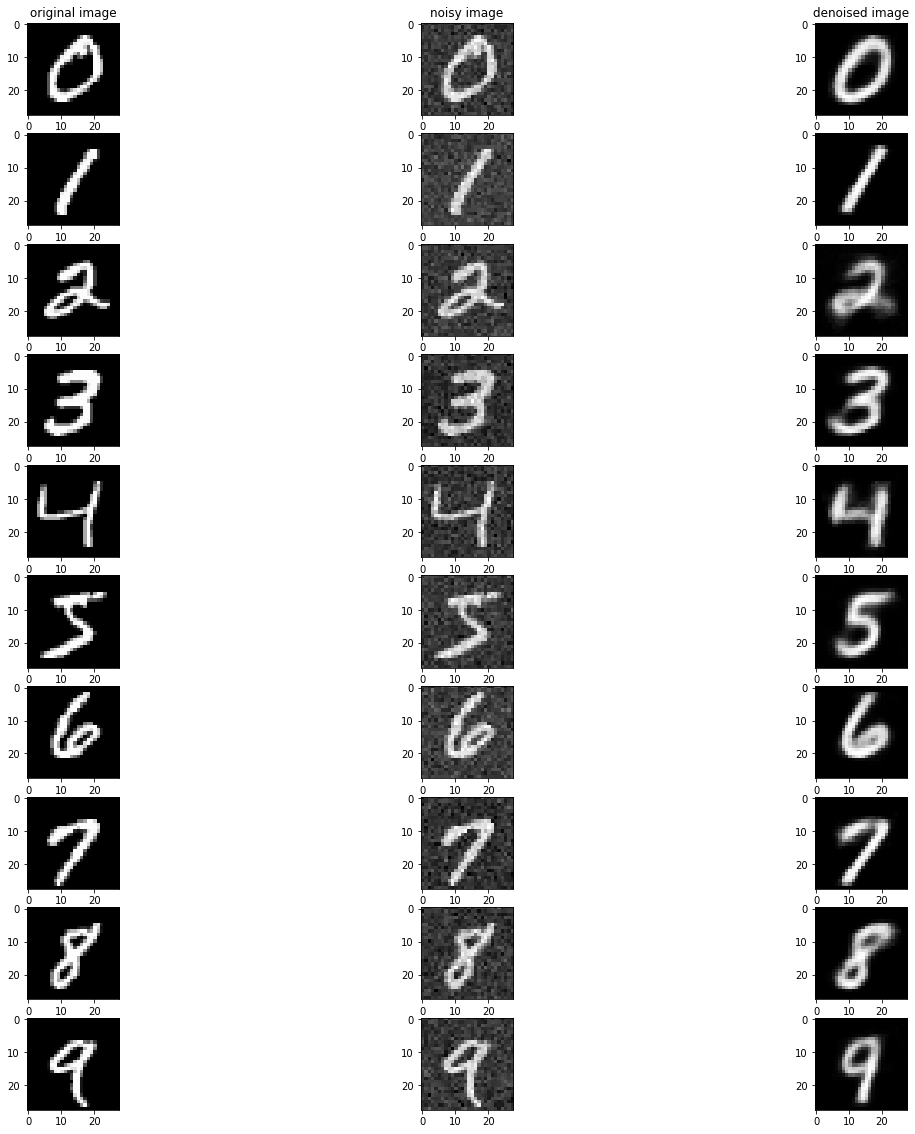

In [ ]:
plt.figure(figsize=(20, 20))

for number in range(0,10):
    
    indice=np.where(original_data.targets==number)[0][0]
    #---------------------------------
    plt.subplot(10,3,(number)*3+1)
    original_image=torch.squeeze(original_data[indice][0])
    plt.imshow(original_image,cmap='gray')
    if(number==0):
      plt.title("original image")
    
    noisy_image=torch.squeeze(noisy_data[indice][0])
    plt.subplot(10,3,(number)*3+2)
    plt.imshow(noisy_image,cmap='gray')
    if(number==0):
      plt.title("noisy image")
    
    image = noisy_data[indice][0].reshape(-1 , 784) 
    image = image.to(device)
    predicted_image=model(image).reshape(-1, 28,28) 
    plt.subplot(10,3,(number)*3+3)
    plt.imshow(predicted_image[0].detach().cpu().numpy(),cmap='gray')

    if(number==0):
       plt.title("denoised image")

### 4.Compute latent feature vectors of images. (The output of the encoder network)

 below you can see latent vectors for one random selection of numbers 

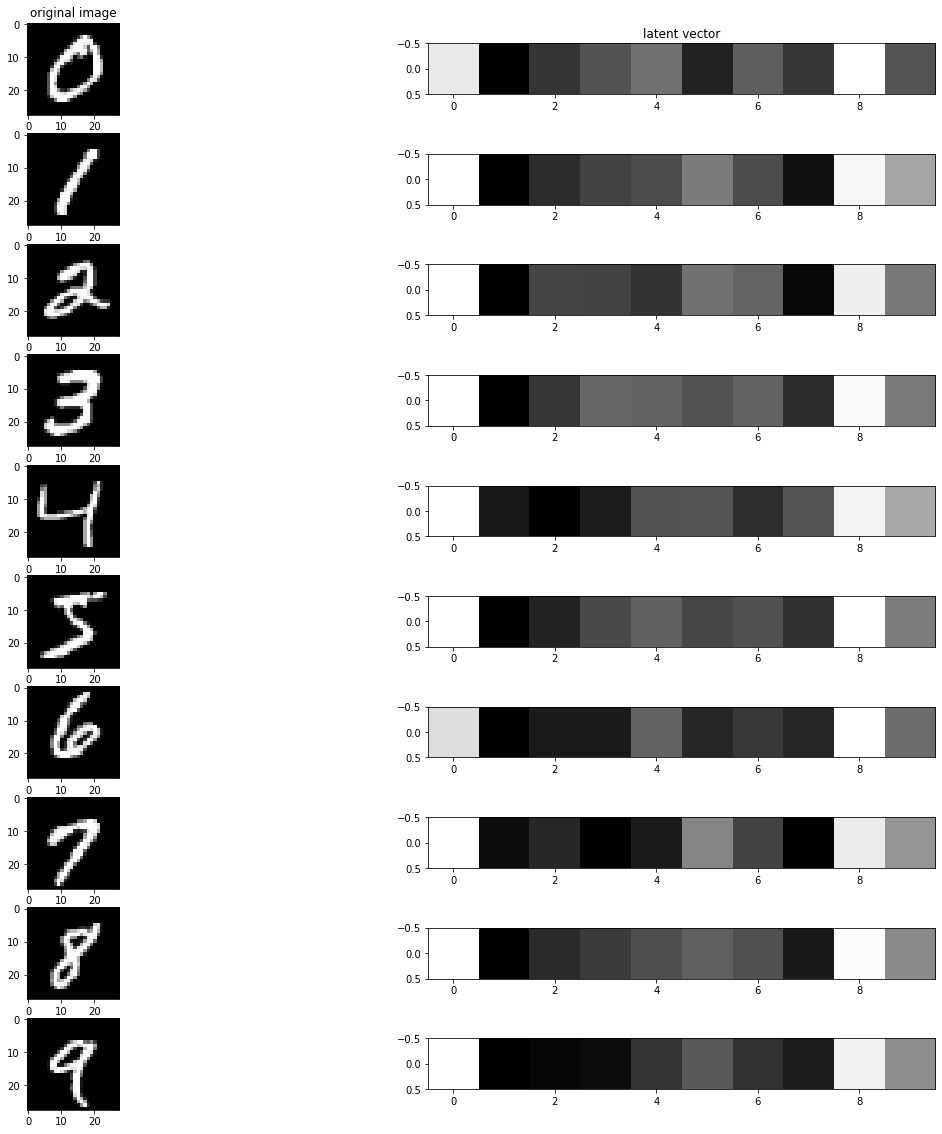

In [ ]:
plt.figure(figsize=(20, 20))

for number in range(0,10):

    indice=np.where(original_data.targets==number)[0][0]
    #--------------------------------
    plt.subplot(10,2,(number)*2+1)
    original_image=torch.squeeze(original_data[indice][0])
    plt.imshow(original_image,cmap='gray')

    if(number==0):
      plt.title("original image")
    #---------------------------------

    plt.subplot(10,2,(number)*2+2)
    image = original_data[indice][0].reshape(-1 , 784) 
    image = image.to(device)
    latent_vector=model.encoder(image).reshape(-1, 10) 
    # latent_features_arr.append(latent_vector.detach().cpu().numpy()[0])
    plt.imshow(latent_vector.detach().cpu().numpy(),cmap='gray')
    if(number==0):
      plt.title("latent vector")
    

## gather latent vectors for all images

In [ ]:
latent_features_arr=[]
labels_arr=[]

for number in range(0,10):

    indice=np.where(original_data.targets==number)[0]


    for ind in indice : 
          
        #--------------------------------
        image = original_data[ind][0].reshape(-1 , 784) 
        image = image.to(device)
        latent_vector=model.encoder(image).reshape(-1, 10) 
        latent_features_arr.append(latent_vector.detach().cpu().numpy()[0])
        labels_arr.append(number)


### 5.Use PCA to reduce the dimensionality of latent features to 2 and visualize the data points in a scatter plot. Use a different color for each digit.

In [ ]:
pca = PCA(n_components = 2)
pca.fit(latent_features_arr)
data_pca = pca.transform(latent_features_arr)
df = pd.DataFrame({'dim1': data_pca[:, 0], 'dim2': data_pca[:, 1]})
df['label'] = labels_arr
fig = px.scatter(df, x = 'dim1',
                    y = 'dim2',
                    color = 'label') 
fig.show()

### 6.TSNE

In [ ]:
vectors_2d= TSNE(n_components=2, init='random').fit_transform(latent_features_arr)
df = pd.DataFrame({'dim1': vectors_2d[:, 0], 'dim2': vectors_2d[:, 1]})
df['label'] = labels_arr
fig = px.scatter(df, x = 'dim1',
                    y = 'dim2',
                    color = 'label') 
fig.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



### 7.What do you conclude from steps 4 and 5 about the learned latent representation of the data?

as model become better, latent vectors become more and more indicator. if we plot them in low dimensional space, they make a clustered space. about these two dimensionality reduction problem, we can say that TSNE is more powerful in tranform our latent vectors into 2d space.  as we can see above, we have segmented space in tsne but for PCA, it's not very clear and seperated. 